In [6]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

import numpy as np
import pandas as pd

#Import torch stuff.
import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

#pip install git+https://github.com/facebookresearch/WavAugment.git
import augment

import IPython.display as ipd
import matplotlib.pyplot as plt

from tqdm import trange, tqdm

#Append the path outside so we can load bom1.
import sys
sys.path.append('..')

import bom1.wakeword as wf
import bom1.bom1 as bom1
from   bom1.toolbox import WakewordDatasetRNN

from sklearn.metrics import accuracy_score

import os

import pickle

In [7]:
import wandb

lr = 3e-5
nepoch = 200
batch_size = 256

config = {
  "learning_rate": lr,
  "epochs": nepoch,
  "batch_size": batch_size
}

wandb.init(project="RNN", entity="wakewordteam", config=config)

wandb: Currently logged in as: rasgaard (use `wandb login --relogin` to force relogin)


In [8]:
#Set the notebook to run on the GPU, if available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'This notebook is running on the {device.type}.')

This notebook is running on the cpu.


In [9]:
folder = '/work3/s164419/01005WakeWordData/RNN_data_10s_shift_5s_1_to_1/train/'
train_dataset = WakewordDatasetRNN(f=lambda x: T.AmplitudeToDB()(T.Spectrogram(hop_length=40)(x)), folder=folder, normalize=True, #normalize the audio when reading it with torchaudio. 
                                              transforms = [#wf.AudioAugment(reverb = 100, snr = 15, pitch = 150, p = [0.5, 0.5, 0.5]),
                                              wf.TransformMono(), 
                                              wf.Padder(22050*10)],
                                              target_length = 1375
                                              ) #sr * length of the clip

folder = '/work3/s164419/01005WakeWordData/RNN_data_10s_shift_5s_1_to_1/val/'
val_dataset = WakewordDatasetRNN(f=lambda x: T.AmplitudeToDB()(T.Spectrogram(hop_length=40)(x)), folder=folder, normalize=True, #normalize the audio when reading it with torchaudio. 
                                              transforms = [#wf.AudioAugment(reverb = 100, snr = 15, pitch = 150, p = [0.5, 0.5, 0.5]),
                                              wf.TransformMono(), 
                                              wf.Padder(22050*10)],
                                              target_length = 1375
                                              ) #sr * length of the clip

folder = '/work3/s164419/01005WakeWordData/RNN_data_10s_shift_5s_1_to_1/test/'
test_dataset = WakewordDatasetRNN(f=lambda x: T.AmplitudeToDB()(T.Spectrogram(hop_length=40)(x)), folder=folder, normalize=True, #normalize the audio when reading it with torchaudio. 
                                              transforms = [#wf.AudioAugment(reverb = 100, snr = 15, pitch = 150, p = [0.5, 0.5, 0.5]),
                                              wf.TransformMono(), 
                                              wf.Padder(22050*10)],
                                              target_length = 1375
                                              ) #sr * length of the clip


train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [10]:
from bom1.models import RNN_V1

rnn = RNN_V1().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.Tensor([20]).to(device))
optimizer = optim.Adam(rnn.parameters(), lr=lr)

In [17]:
with torch.no_grad():
    rnn.load_state_dict(torch.load('../saved_models/RNN_V1/model.pth', map_location=device))

x, targets, paths = next(iter(val_loader))
outputs = rnn(x).squeeze()

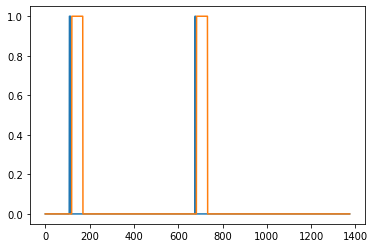

In [70]:
idx = 7

plt.plot(range(1375), (torch.sigmoid(outputs[idx]) > .75).detach())
plt.plot(range(1375), targets[idx].detach())

In [69]:
prediction = (torch.sigmoid(outputs[idx]) > .75)
prediction

torch.Size([1375])

In [67]:
prediction

tensor([[109],
        [110],
        [111],
        [112],
        [113],
        [114],
        [676],
        [677],
        [678]])

In [64]:
target = targets[idx].nonzero().squeeze()

In [71]:
from sklearn.metrics import jaccard_score
jaccard_score(prediction, target)

ImportError: cannot import name 'jaccard_similarity_score'

In [ ]:
def get_metrics(prediction, target):
    prediction_threshold = (prediction > 0.75)


In [ ]:
train_losses = []
val_losses   = []

for epoch in tqdm(range(nepoch), total=nepoch, desc='Epoch'):
    
    train_loss = 0
    val_loss   = 0
    
    for data in train_loader:
        #Reset the gradients.
        optimizer.zero_grad()

        #Fetch the data
        x, targets, path = data

        x = x.to(device)
        targets = targets.to(device)
        #Forward pass
        outputs = rnn(x).squeeze(-1)

        #Calculate the loss
        loss = criterion(outputs, targets) #BCE Loss.
        
        loss.backward()
        optimizer.step()

        contains_phrase = targets.any(dim=1)

        train_loss += loss.item()

    with torch.no_grad():
        for data in val_loader:
            #Fetch the data
            x, targets, path = data
            x = x.to(device)
            targets = targets.to(device)
            
            #Forward pass
            outputs = rnn(x).squeeze(-1)
            
            loss = criterion(outputs, targets) #BCE Loss.
            
            val_loss += loss.item()
            
    #Find the average batch loss.
    train_loss = train_loss / len(train_loader)
    val_loss   = val_loss / len(val_loader)
    
    #Append the training loss and the validation loss.
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    wandb.log({'val_loss': val_loss,'train_loss': train_loss})

    torch.save(rnn.state_dict(), os.path.join('./saved_models/RNN_V1', 'model2.pth'))
    
    print(f'[{epoch}] Train loss: {train_loss}, Val loss: {val_loss}')